# **Langevin Dynamics Simulation**

## **Overview**


### **Questions**

- How can one set up a Langevin Dynamics (LD) simulation in HOOMD-Blue?

### **Objectives**


- Demonstrate how to set up an LD simulation
- Examine the effect of the varying the drag coefficient on basic thermodynamic quantities

## **Workflow**

### **Import packgages**
Let's import the packages needed for the job.

In [3]:
import gsd.hoomd
import hoomd
import matplotlib
import numpy as np
import os

%matplotlib inline
matplotlib.style.use("ggplot")
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

### **Building the polymer**
For this tutorial, we will use a single polymer chain. Let's build a linear polymer with $N$ monomers in a cubic box of length, $L$. The polymer is oriented along the $x-\text{axis}$ and centered in the box. The output is saved in a GSD file, `polymer.gsd`.

We should make sure the file does not already exist in our directory.

In [4]:
file = os.path.join(os.getcwd(), "polymer.gsd")
if os.path.exists(file):
    os.remove(file)

In [5]:
L = 100
N = 30
bond = 1.0
positions = np.zeros((N, 3), dtype=float)
for i in range(N):
    positions[i, 0] = i * bond - (((N-1) * bond) * 0.5)

frame = gsd.hoomd.Frame()
frame.configuration.box = [L, L, L, 0, 0, 0]

# beads
frame.particles.N = N
frame.particles.position = positions
frame.particles.typeid = np.zeros(frame.particles.N, dtype=int)
frame.particles.types  = ["A"]
frame.particles.mass   = np.full(frame.particles.N, 1.0) 

# bonds
frame.bonds.N = N - 1
frame.bonds.typeid = np.zeros(frame.bonds.N, dtype=int)
frame.bonds.types = ["A"]
frame.bonds.group = np.column_stack((range(0, N - 1), range(1, N)))

with gsd.hoomd.open("polymer.gsd", "w") as f:
    f.append(frame)

### **Running the simulation**

The system will be initialized from `polymer.gsd`.

In [42]:
dev = hoomd.device.CPU()
simulation = hoomd.Simulation(device=dev, seed=2)
simulation.create_state_from_gsd(filename="polymer.gsd")

Langevin Dynamics is implemented in HOOMD-Blue as [hoomd.md.methods.Langevin](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/methods/langevin.html). You may refer to the page for a definition of the arguments and a mathematical description. An integration step size of $\Delta t = 0.005$ will be used and $kT=1.0$.

In [43]:
integrator = hoomd.md.Integrator(dt=0.005)
simulation.operations.integrator = integrator

gamma = 1.0
ld = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator.methods.append(ld)

Next up, we can now define the bonded and non-bonded interactions. We will use the Finite Extensible Nonelastic (FENE) potential, with Kremer-Grest parameters for our polymer.

$$
U_{\text{FENE}}(r) = -\dfrac{1}{2} k r_0^2 \ln \left[ 1 - \left( \dfrac{r}{r_0} \right)^2 \right]
$$

where:
- $r$ is the distance between the bonded particles,
- $k$ is the strength of the attractive force,
- $r_0$ is the maximum bond extension (beyond which the force becomes infinite and breaks).

A Weeks-Chandler-Andersen (WCA) potential is also incorporated to model the repulsive interactions.

$$
U_{\text{WCA}}(r) =
\begin{cases}
4\varepsilon \left[ \left( \dfrac{\sigma}{r} \right)^{12} - \left( \dfrac{\sigma}{r} \right)^6 \right] + \varepsilon, & r \leq 2^{1/6} \sigma \\
0, & r > 2^{1/6} \sigma
\end{cases}
$$

where:
- $\varepsilon$ is the repulsive interaction energy,
- $\sigma$ is the repulsive interactive width.

Complete the setup with these paramaters: $k=30$, $r_{0}=1.5$, $\varepsilon = 1.0$ and $\sigma =1.0$. You may use this [documentation](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/bond/fenewca.html) as a guide.

In [44]:
# bonded interactions
fenewca = hoomd.md.bond.FENEWCA()
fenewca.params["A"] = dict(k=30, r0=1.5, epsilon=1.0, sigma=1.0, delta=0.0)
integrator.forces.append(fenewca)

# non-bonded interactions
nl = hoomd.md.nlist.Tree(buffer=1.0, exclusions=["bond"])
wca = hoomd.md.pair.LJ(nlist=nl, default_r_cut=2.0 ** (1.0 / 6.0), mode="shift")
wca.params[("A", "A")] = dict(sigma=1.0, epsilon=1.0)
integrator.forces.append(wca)

Since we we would like to examine whether the drag coefficient affects the potential energy and kinetic temperature, Let's compute and log these quantities. To read further on what thermodynamic quantities can be computed, [refer to this page](https://hoomd-blue.readthedocs.io/en/v5.0.0/hoomd/md/compute/thermodynamicquantities.html).

In [45]:
thermo = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
logger = hoomd.logging.Logger(categories=["scalar"])
logger.add(obj=simulation, quantities=['timestep']) # add timestep to the logger
logger.add(obj=thermo, quantities=['kinetic_energy', 'potential_energy', 'kinetic_temperature']) # add potential energy and kinetic temperature to the logger
output_log = open(f"thermo-{gamma}.dat", "w")
table = hoomd.write.Table(
    trigger=2_000,
    logger=logger,
    output=output_log,
    max_header_len=7
)

The computes and writers have been successfully created but unless appended to the `operations` list, they will have no effect.

Append "thermo" to `simulations.operations.computes`, just as "table" has been appended to the writers below.

In [46]:
simulation.operations.computes.append(thermo)
simulation.operations.writers.append(table)

We will define a gsd writer operation to periodically save trajectories to file.

In [47]:
gs = hoomd.write.GSD(
    trigger=2_000,
    filename="production-"+str(gamma)+".gsd",
    mode="wb",
    dynamic=['property','particles/velocity','particles/image']
)
simulation.operations.writers.append(gs)

We will now produce the simulation data for analyses.

In [48]:
simulation.run(10_000_000, write_at_start=True)

Flush the `GSD` writer after the simulation.

In [49]:
gs.flush()

Having completed with a $\gamma = 0.1$, re-run simulation for 0.01 and 1.0 (and 10 if time permits!).

### **Analyzing the results**

We will analyze the average potential energy and kinetic temperature data as function of $\gamma$.
In each dataset, you may ignore the first half in your analysis.

To begin, let's define a function to help us compute the block averages.

In [40]:
def block_average(data, num_blocks=3):
    traj_length = len(data)
    block_size = traj_length // num_blocks

    blocks = data[:num_blocks * block_size].reshape((num_blocks, block_size))
    block_means = np.mean(blocks, axis=1)

    mean = np.mean(block_means)
    std_error = np.std(block_means, ddof=1) / np.sqrt(num_blocks)

    return mean, std_error


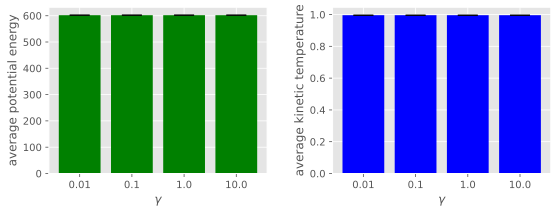

In [50]:
drag = [0.01, 0.1, 1.0, 10.0] #fill in with the gamma values tested 

fig, ax = matplotlib.pyplot.subplots(1, 2, figsize=(9, 3))

pe_data   = np.zeros((len(drag))) # average PE 
pe_err    = np.zeros((len(drag))) # standard error
temp_data = np.zeros((len(drag))) # average temperature
temp_err  = np.zeros((len(drag))) # standard error

for i, d in enumerate(drag):
    data = np.loadtxt(f"thermo-{d}.dat", skiprows=1)
    half = len(data) // 2
    pe_data[i], pe_err[i] = block_average(data[:half, 2])
    temp_data[i], temp_err[i] = block_average(data[:half, 3])

# potential energy
ax[0].bar([i for i in range(len(drag))], pe_data, yerr=pe_err, capsize=10, color='g')
ax[0].set_ylabel("average potential energy")
ax[0].set_xlabel(r"$\gamma$")
ax[0].set_xticks([i for i in range(len(drag))])
ax[0].set_xticklabels(drag)

# kinetic temperature
ax[1].bar([i for i in range(len(drag))], temp_data, yerr=temp_err, capsize=10, color='b')
ax[1].set_ylabel("average kinetic temperature")
ax[1].set_xlabel(r"$\gamma$")
ax[1].set_xticks([i for i in range(len(drag))])
ax[1].set_xticklabels(drag)

matplotlib.pyplot.subplots_adjust(wspace=0.3)
matplotlib.pyplot.show()

We will also examine velocity distributions from the simulation data and compare with the **Maxwell-Boltzmann distribution**. Velocities were saved in the `GSD` file so we will load from there.

The analytical expression of the Maxwell-Boltzmann distribution is given as:

$$
f(v) = 4\pi \left( \frac{m}{2\pi k_B T} \right)^{3/2} v^2 e^{- \frac{mv^2}{2k_B T}}
$$

In this tutorial, both the mass of particle, $m$, and $k_{\text{B}}{T}$ have a value of 1.0.

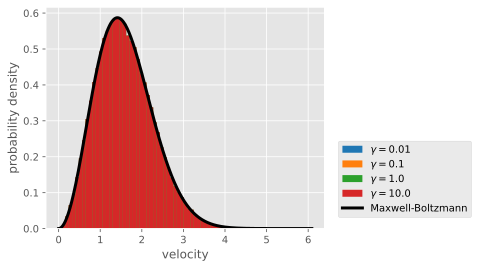

In [68]:
drag = [0.01, 0.1, 1.0, 10.0] #fill in with the gamma values tested 

cmap = matplotlib.pyplot.get_cmap("tab10")
colors = [cmap(j) for j in range(len(drag))]

fig, ax = matplotlib.pyplot.subplots(1, figsize=(5, 4))

# plot velocity distributions
for j, d in enumerate(drag):
    vels = []
    with gsd.hoomd.open(f"production-{d}.gsd") as traj:
        # traj should be an array that contains particle data in all frames
        # loop through each frame and extract the velocity data with frame.particles.velocity[:]
        # the velocity data will be extracted as 3D vectors: (N, 3), but the magnitude is what is needed for the distribution
        # append the speeds of all particles to `vels`
        # Complete this in the loop below to cover all frames  
        for i, frame in enumerate(traj):
            vels.extend(np.linalg.norm(frame.particles.velocity, axis=1))

    vels = np.array(vels)
    ax.hist(vels, bins=75, color=colors[j], density=True, label=r"$\gamma = %s$"%d)

# overlay Maxwell-Boltzmann's distribution
v = np.linspace(0, np.max(vels), len(vels))
MB_dist = 4 * np.pi * (1.0 / (2 * np.pi * 1.0))**1.5 * v**2 * np.exp(-1.0 * v**2 / (2 * 1.0))
ax.plot(v, MB_dist, 'k-', lw=3, label="Maxwell-Boltzmann")
    
ax.set_ylabel("probability density")   
ax.set_xlabel("velocity")
ax.legend(loc=(1.05,0.05))
matplotlib.pyplot.show()